In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 1
SEGMENT = 3

ELECTRON = False
G_COORD = False
L_COORD = False

EPOCH = 40

In [6]:
VIEW_BOUND = (-1000, 1000)
AIR_BOUND = (-500, -499)
BONE_BOUND = (255, 256)
if ELECTRON:
    VIEW_BOUND = (0.5, 1.5)
    AIR_BOUND = (0.5, 0.5009)
    BONE_BOUND = (1.2, 1.2009)    

### Model Settings

#### encoder

In [7]:
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

In [8]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [9]:
DECODER_ATT = "scse"

#### head

In [10]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [11]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [12]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

In [13]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

E_IN_CHANNELS = 1
E_N_CLASSES = 2

# Epochs

In [14]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [15]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [16]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [17]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [18]:
perceptual_ext = PerceptualLoss()

In [19]:
sobel_filter = Sobel().to(device)

In [20]:
def train_d_epoch(epoch, generator, 
                    tf_discriminator, tf_d_optim,
                    edge_discriminator, edge_d_optim,
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data
 
        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)

        y_pr = generator(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update True/Fake D network
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y.float())
        y_pr_cls = tf_discriminator(y_pr.detach())

        tf_dis = 0
        for _y_cls, _y_pr_cls in \
            zip(y_cls, y_pr_cls):
            _B, _C = _y_cls.size()
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_B, dtype=torch.long, device=device)) + \
                            tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (2) Update Edge D network
        ###########################        
        edge_d_optim.zero_grad()        
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
 
        edge_y_cls = edge_discriminator(edge_y.float())
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in \
            zip(edge_y_cls, edge_pr_cls):
            _B, _C = _edge_y_cls.size()
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(_B, dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       

        edge_dis_l += edge_dis.item()


    return  edge_dis_l/(index+1), tf_dis_l/(index+1)

In [21]:
def train_g_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, edge_discriminator, 
                    dataloader, device):
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    tf_gen_l = 0
    edge_gen_l = 0
    self_mae_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)

        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        y_pr = generator(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        assert y_pr.requires_grad, "ct_pred without gradient"
        
        gen_optim.zero_grad()


        # adversarial loss
        y_pr_cls = tf_discriminator(y_pr)
        
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            _B, _C = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        

        edge_y_pr = sobel_filter(y_pr)
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            _B, _C = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) +\
                                    edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        
        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1)

In [22]:
def train_identity_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, edge_discriminator, 
                    dataloader, device):
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    mae_l = 0
    tf_gen_l = 0
    edge_gen_l = 0
    self_mae_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)

        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        y_pr = generator(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        assert y_pr.requires_grad, "ct_pred without gradient"
        
        gen_optim.zero_grad()

       # supervised
        _mae = nn.L1Loss()(y_pr, y)

        # adversarial loss
        y_pr_cls = tf_discriminator(y_pr)
        
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            _B, _C = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        

        edge_y_pr = sobel_filter(y_pr)
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            _B, _C = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) +\
                                    edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss + _mae
        _loss.backward()    
        gen_optim.step()

        
        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), mae_l/(index+1)

In [23]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data
        
        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)

        y_pr = generator(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
    
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y.float())
        for _y_cls in y_cls:
            _y_cls = _y_cls.view(B, T, 2)[:, 1, :]
            _B, _C = _y_cls.size()
            total = _B
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(_B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = _y_pr_cls.view(B, T, 2)[:, 1, :]
            _B, _C = _y_pr_cls.size()
            total = _B
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(_B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]

 
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  

        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        edge_y_cls = edge_discriminator(edge_y.float())
        for _edge_y_cls in edge_y_cls:
            _edge_y_cls = _edge_y_cls.view(B, T, 2)[:, 1, :]
            _B, _C = _edge_y_cls.size()
            total = _B
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros((_B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            _edge_pr_cls = _edge_pr_cls.view(B, T, 2)[:, 1, :]
            _B, _C = _edge_pr_cls.size()
            total = _B
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones((_B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        

        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        x = x.view(B, T, C, H, W)[:, 1, :]
        y = y.view(B, T, 1, H, W)[:, 1, :]
        y_pr = y_pr.view(B, T, 1, H, W)[:, 1, :]
        air_x = air_x.view(B, T, 1, H, W)[:, 1, :]
        bone_x = bone_x.view(B, T, 1, H, W)[:, 1, :]
        
        # main
        _ssim = ssim(y.float(), y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y.float(), 1.0)
        _snr = SNR()(y_pr, y.float())
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [24]:
@torch.no_grad()
def test_epoch(iid, model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = iid
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data
        
        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)

        y_pr = model(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
 
        x = x.view(B, T, C, H, W)[:, 1, :]
        y = y.view(B, T, 1, H, W)[:, 1, :]
        air_x = air_x.view(B, T, 1, H, W)[:, 1, :]
        bone_x = bone_x.view(B, T, 1, H, W)[:, 1, :]
        y_pr = y_pr.view(B, T, 1, H, W)[:, 1, :]

        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0).float()
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [25]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [26]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [27]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [28]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [29]:
from codes.dataset import DicomsSegmentDataset
import codes.augmentation as aug

In [30]:
pelvic_train_case_path = 'raw/train/*_*'
pelvic_train_id_case_path = 'raw/train_id/*_*'
pelvic_test_case_path = 'raw/test/*_*'

In [31]:
trainset_pelvic = DicomsSegmentDataset(pelvic_train_case_path, 
                   intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
trainset_id_pelvic = DicomsSegmentDataset(pelvic_train_id_case_path, 
                   intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=True, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)

In [32]:
testset = DicomsSegmentDataset(pelvic_test_case_path, geometry_aug=aug.get_validation_augmentation(), 
                 identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)

In [33]:
len(trainset_pelvic), len(testset)

(784, 191)

In [34]:
x, y, *_ = trainset_pelvic[20]

In [35]:
x.shape, y.shape

((3, 1, 384, 384), (3, 1, 384, 384))

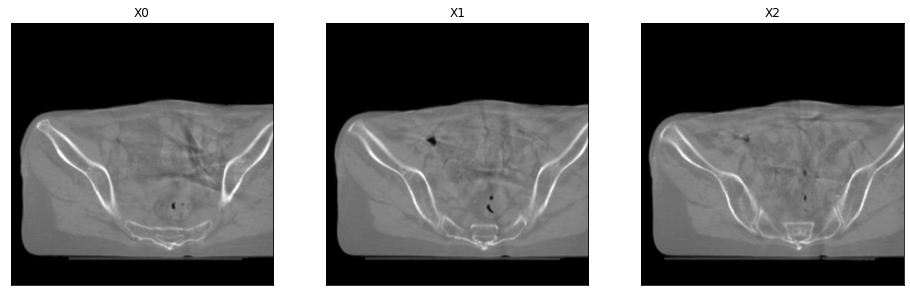

In [36]:
visualize(
    x0 = x[0][0].squeeze(),
    x1 = x[1][0].squeeze(),
    x2 = x[2][0].squeeze())

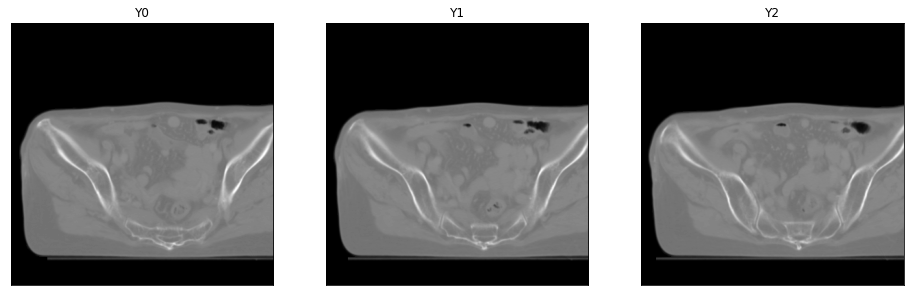

In [37]:
visualize(
    y0 = y[0].squeeze(),
    y1 = y[1].squeeze(),
    y2 = y[2].squeeze())

# training

In [38]:
trainloader = torch.utils.data.DataLoader(trainset_pelvic, batch_size=BATCH, shuffle=True, num_workers=8)
trainloader_id = torch.utils.data.DataLoader(trainset_id_pelvic, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

In [39]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [40]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [41]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [42]:
from codes.temporal_shift import make_temporal_shift

make_temporal_shift(model, SEGMENT, n_div=4, place="blockres")
make_temporal_shift(tf_discriminator, SEGMENT, n_div=4, place="blockres")
make_temporal_shift(edge_discriminator, SEGMENT, n_div=4, place="blockres")

=> n_segment per stage: [3, 3, 3, 3]
=> Using n_round 2 to insert temporal shift
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 8 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 36 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> n_segment per stage: [3, 3, 3, 3]
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold 

In [43]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [44]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
        "electron": ELECTRON,
        "g_coord": G_COORD,
        "l_coord": L_COORD,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [45]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_edge_dis, loss_tf_dis = train_d_epoch(epoch, model,                                                                                              
                                                                                                   tf_discriminator, tf_dis_optimizer, 
                                                                                                    edge_discriminator, edge_dis_optimizer, 
                                                                                                    trainloader, device)
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen = train_g_epoch(epoch, model, gen_optimizer, 
                                                                                                                                             tf_discriminator, edge_discriminator,
                                                                                                                                             trainloader, device)
        loss_air_id, loss_bone_id, loss_edge_gen_id, loss_tf_gen_id, loss_mae = train_identity_epoch(epoch, model, gen_optimizer, 
                                                                                                                                             tf_discriminator, edge_discriminator,
                                                                                                                                             trainloader_id, device)       
        loss_air = (loss_air + loss_air_id) / 2
        loss_bone = (loss_bone + loss_bone_id) / 2
        loss_edge_gen = (loss_edge_gen + loss_edge_gen_id) / 2
        loss_tf_gen = (loss_tf_gen + loss_tf_gen_id) / 2
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, \
        score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, \
        score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))
            print("Epoch={}".format(epoch))

784it [04:52,  2.68it/s]
784it [10:37,  1.23it/s]
560it [06:44,  1.39it/s]
784it [03:11,  4.10it/s]
191it [00:45,  4.23it/s]
784it [04:30,  2.90it/s]
784it [10:25,  1.25it/s]
560it [07:56,  1.17it/s]
784it [02:31,  5.17it/s]
191it [00:36,  5.17it/s]


Epoch=1


784it [04:32,  2.88it/s]
784it [08:26,  1.55it/s]
560it [06:18,  1.48it/s]
784it [02:48,  4.65it/s]
191it [00:36,  5.19it/s]


Epoch=2


784it [04:07,  3.16it/s]
784it [10:49,  1.21it/s]
560it [06:41,  1.39it/s]
784it [03:10,  4.11it/s]
191it [00:46,  4.09it/s]


Epoch=3


784it [04:19,  3.02it/s]
784it [10:02,  1.30it/s]
560it [07:04,  1.32it/s]
784it [03:07,  4.17it/s]
191it [00:46,  4.08it/s]


Epoch=4


784it [04:51,  2.69it/s]
784it [11:08,  1.17it/s]
560it [07:27,  1.25it/s]
784it [02:54,  4.48it/s]
191it [00:43,  4.43it/s]


Epoch=5


784it [04:37,  2.83it/s]
784it [09:57,  1.31it/s]
560it [07:57,  1.17it/s]
784it [02:30,  5.22it/s]
191it [00:36,  5.20it/s]
784it [04:14,  3.08it/s]
784it [09:42,  1.35it/s]
560it [06:15,  1.49it/s]
784it [03:09,  4.14it/s]
191it [00:46,  4.11it/s]
784it [04:53,  2.67it/s]
784it [09:18,  1.40it/s]
560it [06:58,  1.34it/s]
784it [02:29,  5.23it/s]
191it [00:36,  5.22it/s]
784it [04:07,  3.17it/s]
784it [09:50,  1.33it/s]
560it [05:53,  1.58it/s]
784it [03:06,  4.21it/s]
191it [00:45,  4.17it/s]
784it [04:38,  2.81it/s]
784it [09:42,  1.35it/s]
560it [07:46,  1.20it/s]
784it [03:02,  4.29it/s]
191it [00:44,  4.26it/s]
784it [04:42,  2.78it/s]
784it [09:03,  1.44it/s]
560it [07:04,  1.32it/s]
784it [02:30,  5.21it/s]
191it [00:36,  5.19it/s]
784it [04:24,  2.97it/s]
784it [08:51,  1.47it/s]
560it [07:51,  1.19it/s]
784it [02:41,  4.87it/s]
191it [00:45,  4.24it/s]
784it [04:27,  2.93it/s]
784it [08:39,  1.51it/s]
560it [07:10,  1.30it/s]
784it [02:31,  5.19it/s]
191it [00:36,  5.18it/s]


KeyboardInterrupt: 

In [46]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [47]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
make_temporal_shift(model, SEGMENT, n_div=4, place="blockres")

model.load_state_dict(checkpoint["model"])

=> n_segment per stage: [3, 3, 3, 3]
=> Using n_round 2 to insert temporal shift
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 8 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 36 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4


<All keys matched successfully>

In [48]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
make_temporal_shift(tf_discriminator, SEGMENT, n_div=4, place="blockres")

tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

=> n_segment per stage: [3, 3, 3, 3]
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4


<All keys matched successfully>

In [49]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
make_temporal_shift(edge_discriminator, SEGMENT, n_div=4, place="blockres")

edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

=> n_segment per stage: [3, 3, 3, 3]
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4


<All keys matched successfully>

In [50]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:44,  4.30it/s]


(0.3247414752450913,
 8.975101980239309,
 -0.2875144129414209,
 0.2931935572655413,
 0.6217453987404664,
 0.3531730650435754,
 0.0571529313501955,
 1.0,
 1.0)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)